# Phase Picking (PhaseNet), Polarity (DiTingMotion)

Next, I will use `PhaseNet` and `Pyrocko` to pick P and S phases and their polarity.
Lastly, I will use `HASH(fortran)` and `SKHASH (python)` to determine the focal mechanisms.

---

### Import all necessary libraries here, this will make things easier later

In [1]:
import os
import glob
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, Inventory, read, Stream

import tensorflow as tf
from keras import backend as K

# Setup all directories

In [2]:
# set up the project directory
project_dir = f"{os.getcwd()}/../"
data_dir = os.path.join(project_dir, "data/eq_data") # include data folders for eq catalogs, waveforms, and station catalogs
catalog_dir = os.path.join(data_dir, "1_eq_catalogs") # all eq catalogs: orig and edited
waveform_dir = os.path.join(data_dir, "2_waveforms") # mseed files
station_dir = os.path.join(data_dir, "3_station_catalogs") # station xml files

pn_dt_dir = os.path.join(project_dir, "results/phasenet_diting_others") # dir for phasenet,diting,pyrocko
pn_dir = os.path.join(pn_dt_dir, "phasenet_files") # phasenet picks [+added diting & manual picks]
os.makedirs(pn_dir, exist_ok=True)

cwd = os.getcwd()
phasenet_git_path = f"{cwd}/../../../../Software_docs/PhaseNet" # path to source code of PhaseNet

# 1. Use `Phasenet` to pick P and S phases
An example of phasenet terminal code is: \
`python phasenet/predict.py --model=model/190703-214543 --data_list=test_data/mseed.csv --data_dir=test_data/mseed --format=mseed --result_dir./phasenet_results --result_fname=phasenet_phasepick_datetime.csv`

___[[for more details]](https://github.com/AI4EPS/PhaseNet/blob/master/docs/example_batch_prediction.ipynb)

### Make a folder to store the results
- Also make a list of .mseed files (only filename for phasenet) and put it in a .csv file

In [3]:
# Make a list of .mseed files into a csv file to input into PhaseNet command line
mseed_list = [os.path.basename(fname) for fname in glob.glob(f"{waveform_dir}/*.mseed")]

# Write the list to a csv file
pd.DataFrame(mseed_list, columns=["fname"]).to_csv(f"{pn_dir}/mseed_list.csv", index=False, header=True)
print(f"Number of mseed files : {len(mseed_list)}")

Number of mseed files : 921


# *** Run phase net again with only Z channel and on data with few second (~1s) on both sides of initial pick

## Processs the waveforms

In [5]:
import warnings 
warnings.filterwarnings("ignore")

processed_mseed_dir = f"{waveform_dir}/slice_process"
os.makedirs(processed_mseed_dir, exist_ok=True)        # create a directory to store processed waveforms

# picks file
pn_pick_df = pd.read_csv(f"{pn_dir}/ALL_PICKS_POL_921.csv", parse_dates=['phase_time'])
pn_pick_df = pn_pick_df[pn_pick_df["phase_type"] == "P"]        # only P picks
grouped_pn_pick_df = pn_pick_df.groupby("file_name")            # group by event_id.mseed

if input("Process mseeds again? (y/n): ") == 'n':
    raise SystemExit

for file_name, group in grouped_pn_pick_df:
    group.sort_values(by='phase_score', ascending= False)         # sort by best picks to least
    event_id = file_name.split(".")[0]  

    # read and resample original wf  
    st_0 = obspy.read(f"{waveform_dir}/{file_name}")
    st = st_0.copy()
    st.resample(100)            # resample to 100 Hz 
    processed_st = Stream()     # empty stream to store processed waveforms
    
    for idx, row in group.iterrows():
        phase_time = UTCDateTime(pd.to_datetime(str(row.phase_time)))
        station_id = f'{row.station_id}Z'      # keep only Z component
        tr = st.select(id=station_id)[0]

        if len(tr.data) == 0 or np.max(tr.data) == 0:
            continue

        tr.detrend("demean")            # remove mean
        try:
            tr.detrend('linear')        # remove trend
        except:
            tr.detrend('constant')      # remove trend
        
        tr.taper(0.001)
        tr.filter("bandpass", freqmin=1.5, freqmax=10)
        
        # Use variable gain to amplify the signal
        # print(len(tr.data), tr.data.shape)
        tr.data = tr.data / np.max(tr.data) # normalize the data
        zoom = 2
        spread = np.std(tr.data)          
        vzoom = zoom/np.round(spread, 2)/10 if spread != 0 else zoom
        tr.data = tr.data * vzoom

        offset = 0.64       # x seconds before and after the phase time
        tr = tr.slice((phase_time - (offset-0.01)), (phase_time + offset)) # 100 hz, meaning 1s == 100 samples

        if idx == 1: 
            print("Sample length: ", len(tr.data))
        
        if (len(tr.data)) != 128:
            continue

        # add the processed trace to the stream
        if len(tr.data) > 0 and np.max(tr.data) > 0:    
            processed_st += tr

    # write the processed stream to a file
    if len(processed_st) != 0:
       processed_st.write(f"{processed_mseed_dir}/{event_id}.mseed", format="MSEED")
    print(len(st), 'vs processed:', len(processed_st), processed_st)
    # break  

Sample length:  128
94 vs processed: 25 25 Trace(s) in Stream:

XQ.ME31.01.BHZ | 2008-04-04T17:11:29.615000Z - 2008-04-04T17:11:30.885000Z | 100.0 Hz, 128 samples
...
(23 other traces)
...
XQ.ME15.01.BHZ | 2008-04-04T17:11:53.705000Z - 2008-04-04T17:11:54.975000Z | 100.0 Hz, 128 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
108 vs processed: 11 11 Trace(s) in Stream:
XQ.ME36.01.BHZ | 2008-04-16T16:47:26.955000Z - 2008-04-16T16:47:28.225000Z | 100.0 Hz, 128 samples
XQ.ME34.01.BHZ | 2008-04-16T16:47:30.105000Z - 2008-04-16T16:47:31.375000Z | 100.0 Hz, 128 samples
NC.KCT..HNZ    | 2008-04-16T16:47:31.167700Z - 2008-04-16T16:47:32.437700Z | 100.0 Hz, 128 samples
NC.KMR..HNZ    | 2008-04-16T16:47:31.417700Z - 2008-04-16T16:47:32.687700Z | 100.0 Hz, 128 samples
XQ.ME33.01.BHZ | 2008-04-16T16:47:32.075000Z - 2008-04-16T16:47:33.345000Z | 100.0 Hz, 128 samples
XQ.ME37.01.BHZ | 2008-04-16T16:47:32.235000Z - 2008-04-16T16:47:33.505000Z | 100.0 Hz, 128 samples
XQ.ME35.

Check the smaller wfs and plot old ppick time over them

nc40215740.mseed
18 19


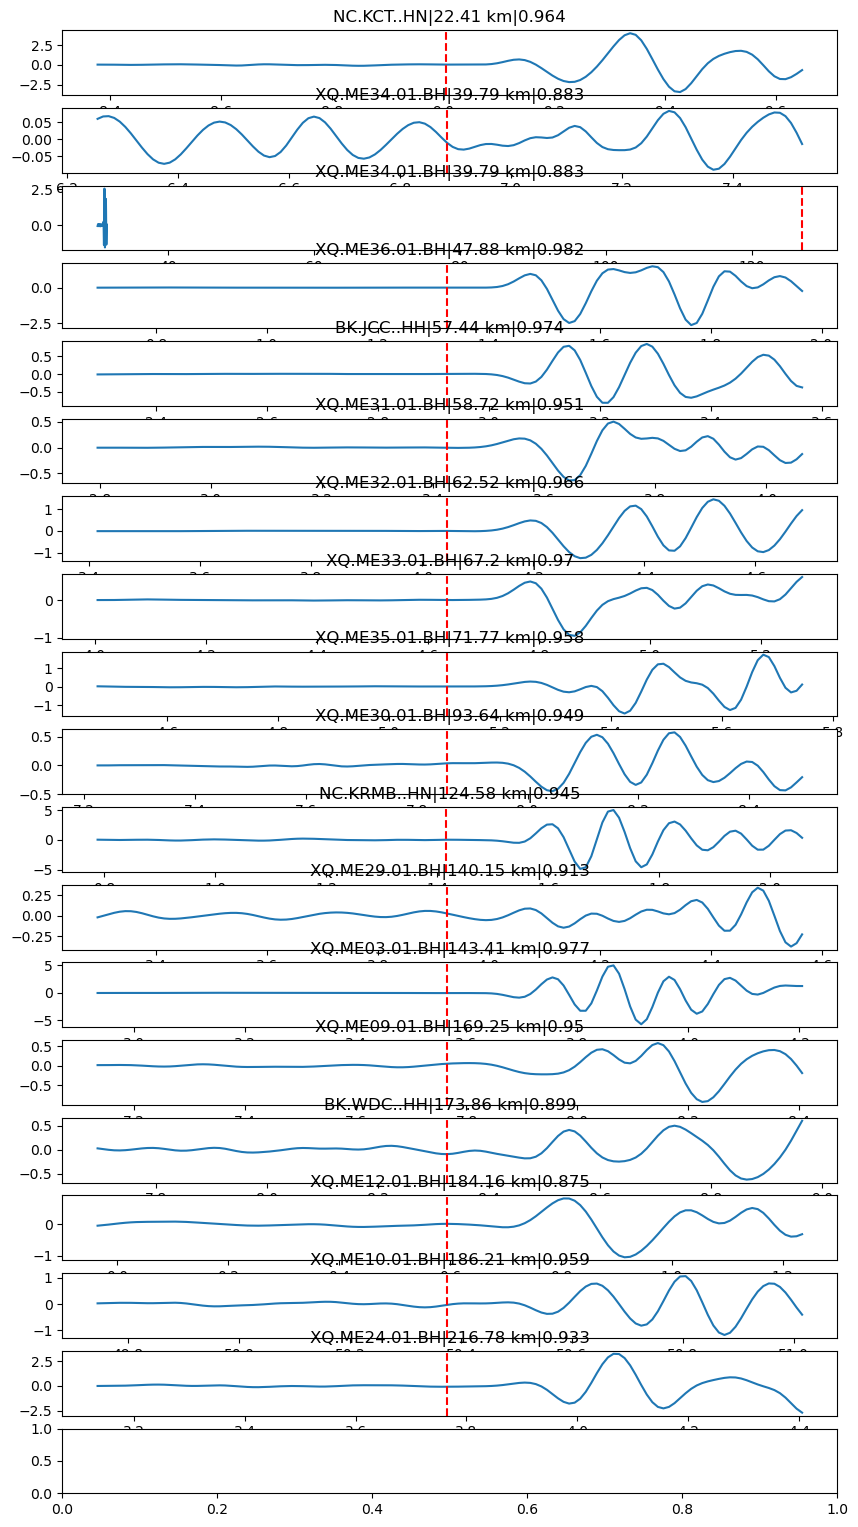

In [55]:
from classes_functions.wf_plotter import plot_wf_check_picks

mseed_list_processed = [f for f in os.listdir(processed_mseed_dir) if f.endswith('.mseed')]
selected_file = mseed_list_processed[0]
print(selected_file)

st = read(f"{processed_mseed_dir}/{selected_file}")
event_df = pn_pick_df[pn_pick_df["file_name"] == f"{selected_file}"].sort_values('sta_dist_km',ascending=True).reset_index(drop=True)
print(len(st), len(event_df))    

fig, axs = plt.subplots(len(event_df), 1, figsize=(10, len(event_df)))

for i, tr in enumerate(st):
    station_id = tr.id[:-1]
    row = event_df[event_df["station_id"] == station_id]
    timex = np.arange(tr.stats.starttime, tr.stats.endtime+tr.stats.delta, tr.stats.delta)
    axs[i].plot(timex, tr.data, label=station_id)
    if len(row) > 0:
        pn_time = UTCDateTime(pd.to_datetime(row.phase_time.values[0]))
        axs[i].axvline(pn_time, color='r', linestyle='--', label='P pick')
        axs[i].set_title(f"{station_id}|{row.sta_dist_km.values[0]} km|{row.phase_score.values[0]}")

# Run phasenet again on the processed data

In [89]:
import os
# Make a list of .mseed files into a csv file to input into PhaseNet command line
processed_mseed_list = [f for f in os.listdir(f"{waveform_dir}/processed") if f.endswith(".mseed")]

# Write the list to a csv file
pd.DataFrame(processed_mseed_list, columns=["fname"]).to_csv(f"{pn_dir}/processed_mseed_list.csv", index=False, header=True)
print(f"Number of mseed files : {len(processed_mseed_list)}")

Number of mseed files : 248


In [92]:
from classes_functions.other_fun import make_phasenet_script
%reload_ext autoreload
%autoreload 2

script_content = make_phasenet_script(
    phasenet_git_path,
    waveform_dir=f"{waveform_dir}/processed",
    data_list=f"{pn_dir}/processed_mseed_list.csv",
    result_dir=pn_dir,
    result_fname='phasenet_phasepick_3d_grid_new_processed',
    min_p_prob=0.85,
    conda_env='anaconda3',
    )
# print(script_content)

# Write the script content to a file
with open(f"{pn_dir}/run_phasenet_processed.sh", "w") as f:
    f.write(script_content)

# Make the script executable
print("Making the script executable...")
os.system(f"chmod +x {pn_dir}/run_phasenet_processed.sh")

Making the script executable...


0

In [93]:
# Run the script
run = input("Do you want to run PhaseNet now \n on the PROCESSED DATA? (y/n): ")
if run.lower() == "y":
    print("Running PhaseNet...")
    os.system(f"{pn_dir}/run_phasenet_processed.sh")
else:
    print("PhaseNet already run. Skipping...")

Running PhaseNet...


2024-04-22 14:54:27,133 Pred log: /Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/code/../results/phasenet_diting_others/phasenet_files
2024-04-22 14:54:27,133 Dataset size: 248
2024-04-22 14:54:27,196 Model: depths 5, filters 8, filter size 7x1, pool size: 4x1, dilation rate: 1x1
2024-04-22 14:54:27.226715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'create_inputs/is_training' with dtype bool
	 [[{{node create_inputs/is_training}}]]
2024-04-22 14:54:27.235763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'create_inputs/is_training' with dtype bool
	 [[{

Done with 5839 P-picks and 0 S-picks


12 9


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

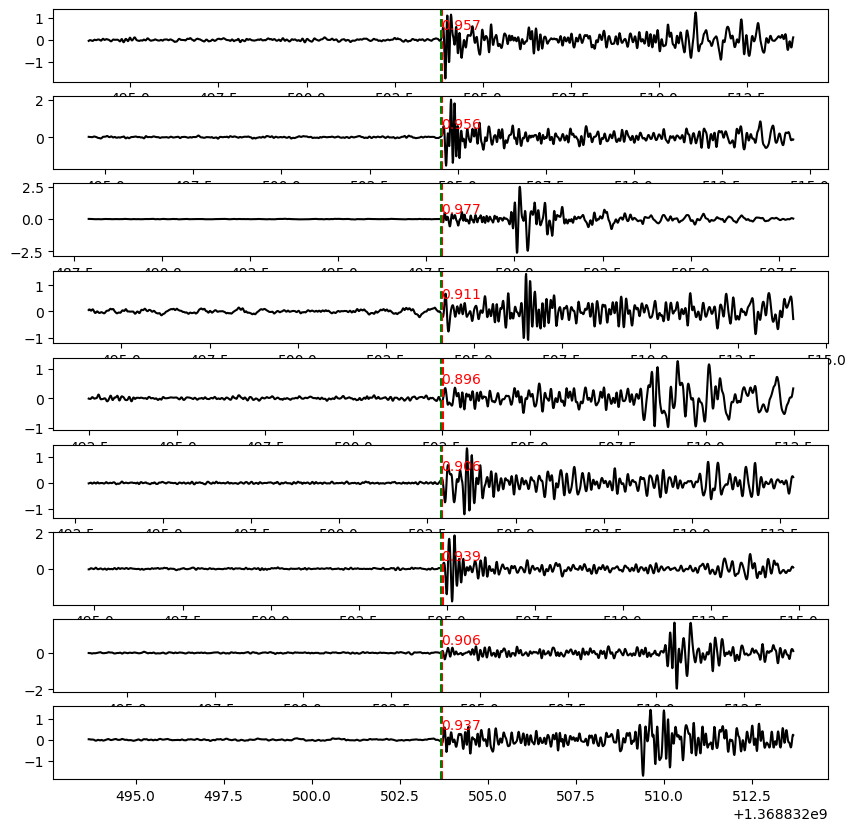

In [101]:
pn_pick_df = pd.read_csv(f"{pn_dir}/dt_pn_varified.csv", parse_dates=['phase_time'])
pn_pick_df2 = pd.read_csv(f"{pn_dir}/phasenet_phasepick_3d_grid_new_processed.csv", parse_dates=['begin_time', 'phase_time'])
selected_file = processed_mseed_list[0]
event_df = pn_pick_df2[pn_pick_df2["file_name"] == selected_file].reset_index(drop=True)
st = read(f"{waveform_dir}/processed/{selected_file}")

print(len(st), len(event_df))
# st.plot();

fig, axs = plt.subplots(len(event_df), 1, figsize=(10,10))
axs = axs.flatten()

for i, row in event_df.iterrows():
    phasetime1 = pn_pick_df.loc[
        (pn_pick_df["file_name"] == row.file_name) & 
        (pn_pick_df["station_id"] == row.station_id) & 
        (pn_pick_df["phase_type"] == "P")
    ]["phase_time"].values[0]
    phasetime = UTCDateTime(pd.to_datetime(str(phasetime1)))        # 1st pick time
    phasetime2 = UTCDateTime(pd.to_datetime(str(row.phase_time)))   # 2nd pick time [on processed data]
    tr = st.select(id=f"{row.station_id}Z")[0]

    xtimes = np.arange(tr.stats.starttime, tr.stats.endtime+tr.stats.delta, tr.stats.delta)
    axs[i].plot(xtimes, tr.data, color='k')
    axs[i].axvline(phasetime2, color='r', linestyle='--')
    axs[i].axvline(phasetime, color='g', linestyle='--')
    axs[i].text(phasetime, 0.5, row.phase_score, color='r')

plt.xlim(tr.stats.starttime, tr.stats.endtime)

plt.tight_layout()
plt.show()

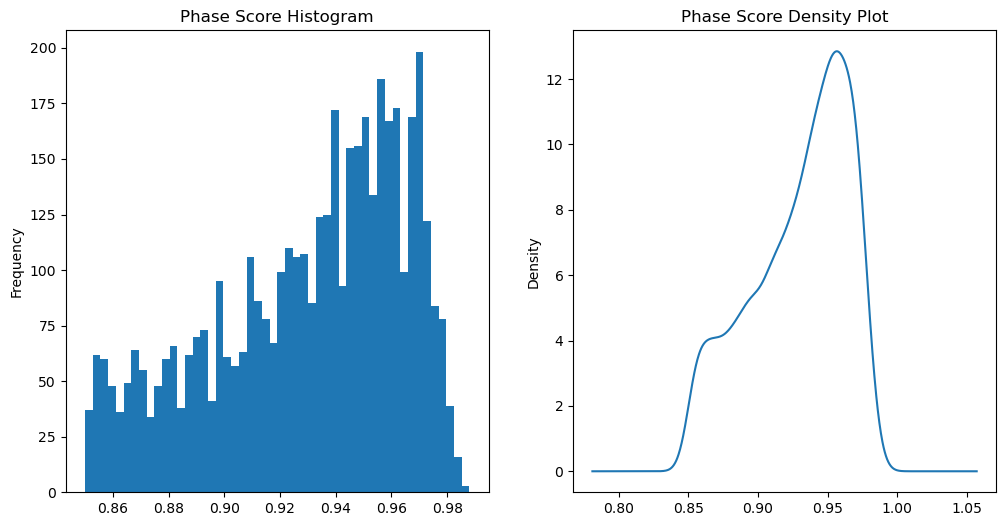

In [9]:
# plot phase_score distribution as histogram and density plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pn_pick_df["phase_score"].plot(kind="hist", bins=50, ax=ax[0], title="Phase Score Histogram")
pn_pick_df["phase_score"].plot(kind="kde", ax=ax[1], title="Phase Score Density Plot")

plt.show()

# 2. Determine polarity using DitingMotion

In [10]:
# phasnet_picks = f"{pn_dir}/phasenet_phasepick_3d_grid_new_processed.csv"
# phasenet_df = pd.read_csv(phasnet_picks, parse_dates=["begin_time", "phase_time"])
# phasenet_df = phasenet_df[(phasenet_df.phase_type == "P")] # filter out only P picks

pn_pick_df = pn_pick_df[pn_pick_df["phase_type"] == "P"]        # only P picks

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
diting_model_dir = "./DiTing_model/models/DiTingMotionJul.hdf5"
diting_model = tf.keras.models.load_model(diting_model_dir, compile=False)

## Use function in my custom clases

suddenly parallelized function causing issues with tensorflow, but regular for loop is okay.

In [12]:
from classes_functions.my_class_funcs import DitingMotionPicker
%reload_ext autoreload

run = input("Do you want to run DiTing Motion Picker now? (y/n): ")
if run.lower() == "y":
    dmp = DitingMotionPicker(
        mseed_list=processed_mseed_list,
        waveform_dir=f"{waveform_dir}/processed",
        phasenet_picks_df=pn_pick_df,
        motion_model=diting_model,
        )
    if input("Parallelize? (y/n): ") == 'n':
        pol_pick_df = dmp.assign_polarity()
    else:
        pol_pick_df = dmp.assign_polarity_parallel()

    print(pol_pick_df.shape)
    pol_pick_df.to_csv(f"{pn_dir}/diting_phasenet_3d_grid_processed.csv", index=False)

else:
    print("DiTing Motion Picker already run. Skipping...")

/Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/code/classes_functions/my_class_funcs.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phasenet_picks_df['diting_polarity'], phasenet_picks_df['diting_sharpness'] = None, None
/Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/code/classes_functions/my_class_funcs.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phasenet_picks_df['diti

(4484, 11)


<Axes: title={'center': 'DiTing Polarity Distribution'}, xlabel='diting_polarity'>

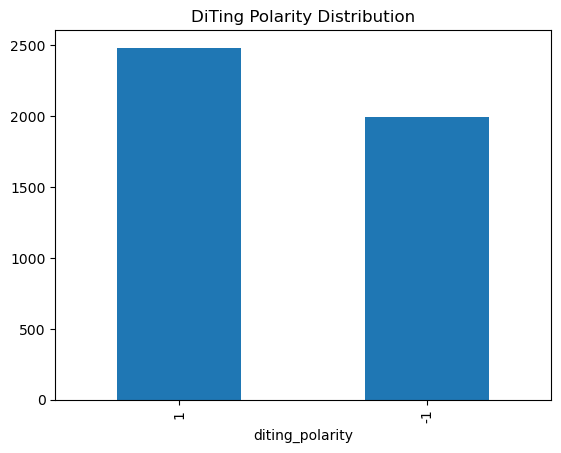

In [13]:
pol_pick_df.diting_polarity.value_counts().plot(kind='bar', title='DiTing Polarity Distribution')

# 3. Convert PyRocko picks into phasenet format csv file
add pyrocko phase time, phase polarity as new columns to the phasenet pick file.

## plot

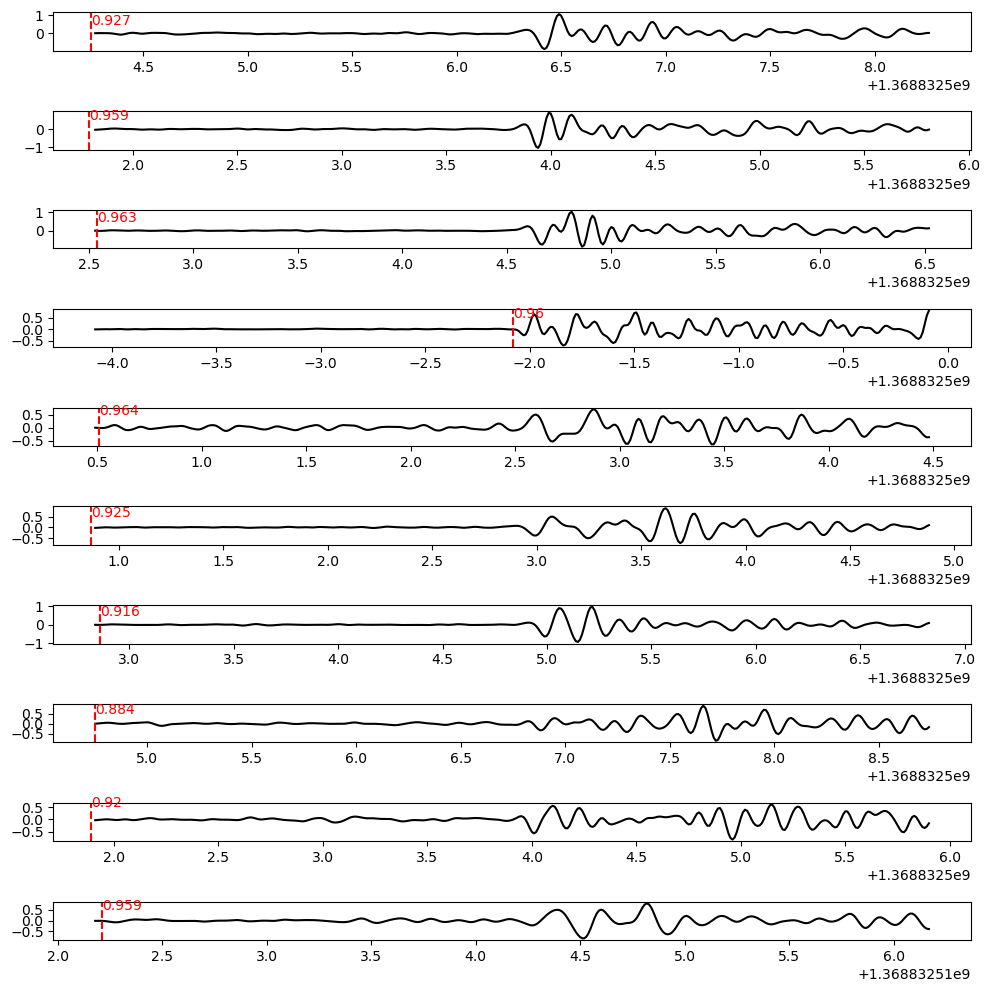

In [33]:
pol_pick_df = pd.read_csv(f"{pn_dir}/diting_phasenet_3d_grid_processed.csv", parse_dates=['begin_time', 'phase_time'])  

selected_file = processed_mseed_list[0]
st = read(f"{waveform_dir}/processed/{selected_file}")

fig, axs = plt.subplots(10, 1, figsize=(10,10))
axs = axs.flatten()

for i, row in pol_pick_df[pol_pick_df.file_name == selected_file].iterrows():
    phasetime = UTCDateTime(pd.to_datetime(str(row.phase_time)))
    tr = st.select(id=f"{row.station_id}Z")[0]

    xtimes = np.arange(tr.stats.starttime, tr.stats.endtime+tr.stats.delta, tr.stats.delta)
    axs[i].plot(xtimes, tr.data, color='k')
    axs[i].axvline(phasetime, color='r', linestyle='--')
    axs[i].text(phasetime, 0.5, row.phase_score, color='r')



plt.tight_layout()
plt.show()
    